## 1. Project Setup

**Load Data & Packages**

In [52]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB, GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
import os
import analyze_k
SEED = 12

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

import load_data as ld
df, train_indices, valid_indices= ld.load_train_data()
from evaluate_classification import evaluate_classification
from sklearn.model_selection import train_test_split
from evaluate_classification import evaluate_classification
import loops

df, train_indices, valid_indices = ld.load_train_data(filepath = 'Kaggle_download/train.csv')
scaler = MinMaxScaler()

import warnings
warnings.filterwarnings('ignore')

In [53]:
# %cd "/Users/andrewdunn/Desktop/Classes/UChicago/"CAPP 30254 - Machine Learning"/Costa-Rican-Household-Poverty-Level-Prediction/ml_model_testing"


### Out of the Box

#### Naive Bayes

In [54]:
nb = ComplementNB()
nb_results = loops.loop_model(nb, df, train_indices, valid_indices, inc_cm=False)

In [55]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.5099199275669863,
 'f1': 0.4966067069661597,
 'Macro f1': 0.24699386946327015,
 'recall_1': 0.0,
 'precision_1': 1.0,
 'recall_2': 0.5792390194075587,
 'precision_2': 0.20278332354668233,
 'recall_3': 0.0,
 'precision_3': 1.0,
 'recall_4': 0.6448252344416028,
 'precision_4': 0.7369148205118234}

### KNN 

In [56]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_results = loops.loop_model(knn, df, train_indices, valid_indices, inc_cm=False)

In [57]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.6111648699883994,
 'f1': 0.5522241234977233,
 'Macro f1': 0.27882688713612136,
 'recall_1': 0.0496969696969697,
 'precision_1': 0.13275443510737628,
 'recall_2': 0.1335035750766088,
 'precision_2': 0.2462605516007313,
 'recall_3': 0.0704225352112676,
 'precision_3': 0.1503950838433597,
 'recall_4': 0.8812735261328613,
 'precision_4': 0.693013944692242}

#### Random Forest

In [58]:
clf = RandomForestClassifier(random_state = SEED)
clf_results = loops.loop_model(clf, df, train_indices, valid_indices, inc_cm=False)


In [59]:
avg_clf = analyze_k.average_outcome(clf_results)
avg_clf

{'accuracy': 0.6807973290326231,
 'f1': 0.6178342646334354,
 'Macro f1': 0.3696063708466068,
 'recall_1': 0.171010101010101,
 'precision_1': 0.48437314319667263,
 'recall_2': 0.24415219611848826,
 'precision_2': 0.37405578653277366,
 'recall_3': 0.0647887323943662,
 'precision_3': 0.3512698412698413,
 'recall_4': 0.9493396288281198,
 'precision_4': 0.7297469089790025}

#### Logistic Regression

In [60]:
lr = LogisticRegression(solver='liblinear', penalty='l2')
lr_results = loops.loop_model(lr, df, train_indices, valid_indices, inc_cm=False)

In [61]:
avg_lr = analyze_k.average_outcome(lr_results)
avg_lr

{'accuracy': 0.6609518150694622,
 'f1': 0.5580146369784441,
 'Macro f1': 0.25858841441938396,
 'recall_1': 0.026767676767676767,
 'precision_1': 0.8833333333333332,
 'recall_2': 0.083682328907048,
 'precision_2': 0.3107878787878787,
 'recall_3': 0.03098591549295775,
 'precision_3': 0.2590476190476191,
 'recall_4': 0.9780011804052725,
 'precision_4': 0.6830114041123088}

### Final Models

#### Naive Bayes

In [62]:
nb = ComplementNB()
nb_results = loops.loop_model(nb, df, train_indices, valid_indices, oversample=ld.gen_SMOTE_data, var_thresh=False, scaler=scaler, inc_cm=False)

In [63]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.625626573861868,
 'f1': 0.5968381578946687,
 'Macro f1': 0.3392767645689586,
 'recall_1': 0.11666666666666667,
 'precision_1': 0.17139725945696097,
 'recall_2': 0.4341930541368743,
 'precision_2': 0.3091653554313483,
 'recall_3': 0.04507042253521126,
 'precision_3': 0.23177489177489177,
 'recall_4': 0.8321411240081316,
 'precision_4': 0.7701074508014218}

#### KNN

In [64]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_results = loops.loop_model(knn, df, train_indices, valid_indices, scaler=scaler, var_thresh=True, inc_cm=False)

In [65]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.6575825481707834,
 'f1': 0.5690542817375487,
 'Macro f1': 0.28159595448080627,
 'recall_1': 0.05848484848484849,
 'precision_1': 0.22222222222222224,
 'recall_2': 0.11989274770173645,
 'precision_2': 0.31536334633108826,
 'recall_3': 0.03098591549295775,
 'precision_3': 0.27939393939393936,
 'recall_4': 0.9611095809561283,
 'precision_4': 0.6943089576936049}

#### Random Forest

In [66]:
# set seed to its value in Random_Forest, where extensive testing occurred
SEED = 0

os_clf = make_pipeline(RandomOverSampler(random_state=SEED),
                        RandomForestClassifier(random_state = SEED,
                                               n_estimators = 600,
                                                min_samples_split = 5,
                                                min_samples_leaf = 4,
                                                max_features = 'auto',
                                                max_depth = 10,
                                                bootstrap = True))


clf_results = loops.loop_model(os_clf, df, train_indices, valid_indices, scaler=scaler, var_thresh=True, inc_cm=False)
analyze_k.average_outcome(clf_results)

{'accuracy': 0.5876286676286677,
 'f1': 0.6131636027178089,
 'Macro f1': 0.40537996288389416,
 'recall_1': 0.31555555555555553,
 'precision_1': 0.2531427916803729,
 'recall_2': 0.3685137895812053,
 'precision_2': 0.2788576238576238,
 'recall_3': 0.2732394366197183,
 'precision_3': 0.21573267577625552,
 'recall_4': 0.7251701750934487,
 'precision_4': 0.8587612581698391}

In [67]:
# Change seed back to original value
SEED = 12


#### Logistic Regression

{'accuracy': 0.6057935093229212,
 'f1': 0.6149668029480223,
 'Macro f1': 0.3927558446468965,
 'recall_1': 0.1801010101010101,
 'precision_1': 0.28984126984126984,
 'recall_2': 0.567849846782431,
 'precision_2': 0.26934828134504596,
 'recall_3': 0.15492957746478875,
 'precision_3': 0.29082591123054796,
 'recall_4': 0.7446468620893174,
 'precision_4': 0.8483324879237353}

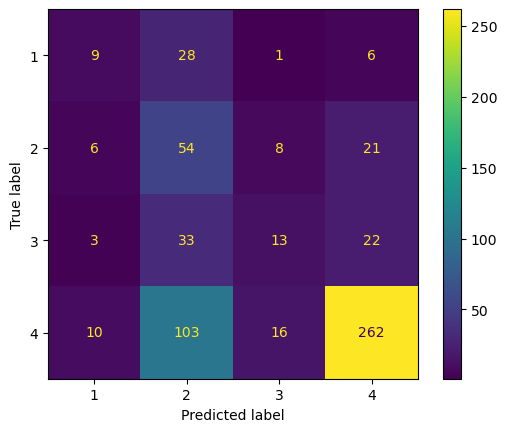

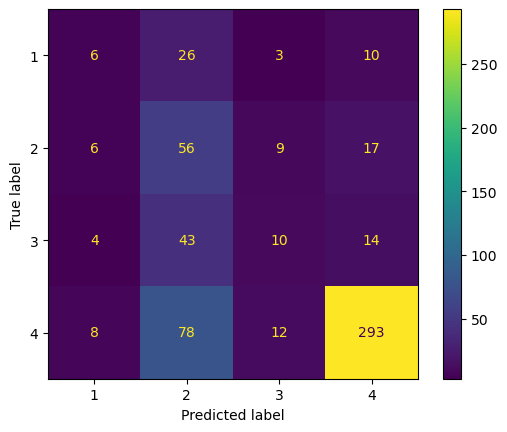

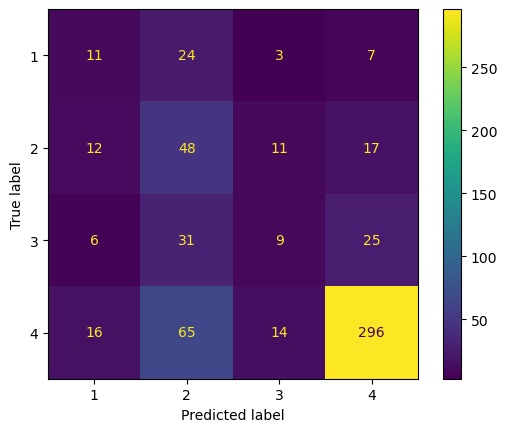

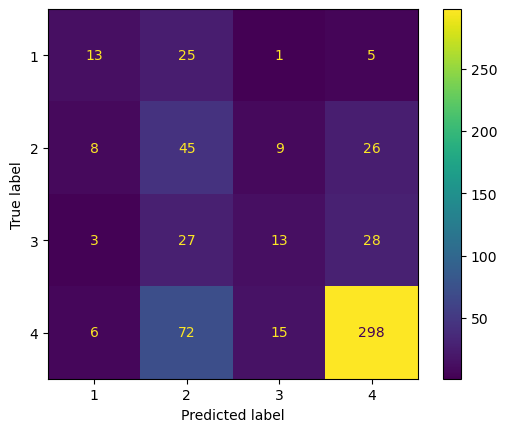

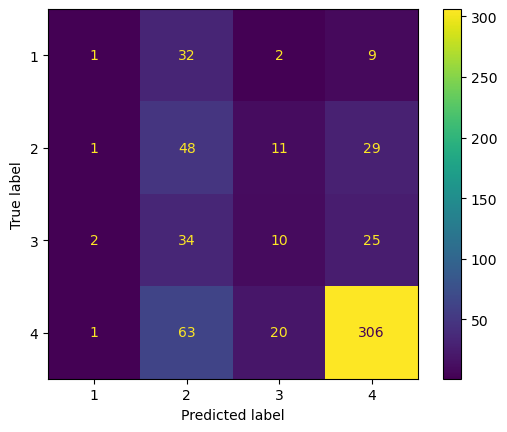

In [68]:
reg = LogisticRegression(solver='liblinear', penalty='l2')
results = loops.loop_model(reg,df,train_indices,valid_indices,oversample=ld.gen_SMOTE_data,var_thresh=True)
avg = analyze_k.average_outcome(results)
avg


### Two Stage Classification

Accuracy: 0.61
Weighted F1 Score: 0.62
Macro F1 Score: 0.43
Precision: Class 1: 0.32 Class 2: 0.24  Class 3: 0.29
           Class 4: 0.83
Recall: Class 1: 0.53 Class 2: 0.15  Class 3: 0.43
        Class 4: 0.76


Accuracy: 0.66
Weighted F1 Score: 0.63
Macro F1 Score: 0.39
Precision: Class 1: 0.38 Class 2: 0.32  Class 3: 0.28
           Class 4: 0.8
Recall: Class 1: 0.14 Class 2: 0.49  Class 3: 0.09
        Class 4: 0.87




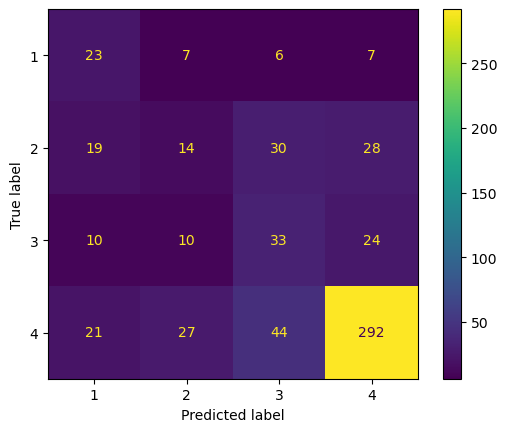

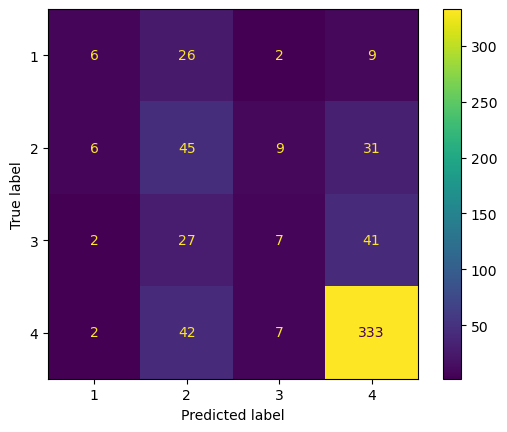

In [69]:
X = df.drop(columns="Target")
y = df.loc[:, 'Target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
train_df_resampled, train_y_resampled = ld.gen_oversample_data(train, seed = 12)
X_smote, y_smote = ld.gen_SMOTE_data(train, seed = 12)


def Two_stage(model1, model2):
    #Fit First Layer
    reg=model1.fit(X_smote, y_smote)
    y_pred = reg.predict(X_valid)
   
    #Take first layer predictions and get rid of obs we predicted
    #4 on in test set
    y_pred= pd.DataFrame(y_pred, columns=["pred"])
    a= pd.concat([X_valid.reset_index(drop=True), y_pred], axis=1)
    new_test_set= a.loc[a.loc[:,"pred"]!= 4,:]

    #Run Layer 2 on non-4 obs
    rev_dataset=pd.concat([X_smote, y_smote], axis=1)
    rev_dataset= rev_dataset.loc[rev_dataset.loc[:,"Target"]!= 4, :]
    Y= rev_dataset.loc[:,"Target"]
    X= rev_dataset.drop(columns="Target")
    reg= model2.fit(X, Y)

    #run fit on revised test set
    new_pred = reg.predict(new_test_set.drop(columns="pred"))
    #combine predictions
    a.loc[a.loc[:,"pred"]!= 4,"pred"]=new_pred
    #evaluate
    evaluate_classification(a.loc[:,"pred"], y_true = y_valid, l=[1,2,3,4], cm = True)

os_clf = make_pipeline(RandomOverSampler(random_state=0),
                        RandomForestClassifier(random_state = 0,
                                               n_estimators = 600,
                                                min_samples_split = 5,
                                                min_samples_leaf = 4,
                                                max_features = 'auto',
                                                max_depth = 10,
                                                bootstrap = True))


Two_stage(LogisticRegression(solver='liblinear', penalty='l2'),os_clf)
Two_stage(os_clf,LogisticRegression(solver='liblinear', penalty='l2'))

### Binary Model

In [70]:
# Recode target classes in the DataFrame
bin_df = df.copy()
bin_df['Target'] = bin_df['Target'].replace({1: 1, 2: 1, 3: 0, 4: 0})

X_train = bin_df.drop(columns="Target")
y_train = bin_df.loc[:, 'Target']

### Naive Bayes

{'accuracy': 0.7292255892255893,
 'f1': 0.7481186203520743,
 'Macro f1': 0.6736515839684861,
 'recall_non_pov': 0.7345202880994638,
 'recall_pov': 0.710788334472545,
 'precision_non_pov': 0.8986702256191526,
 'precision_pov': 0.43446361181483895}

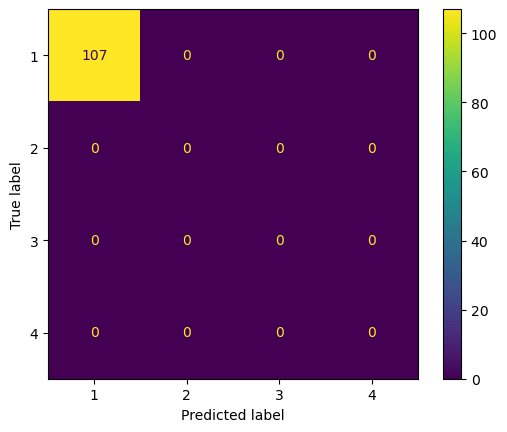

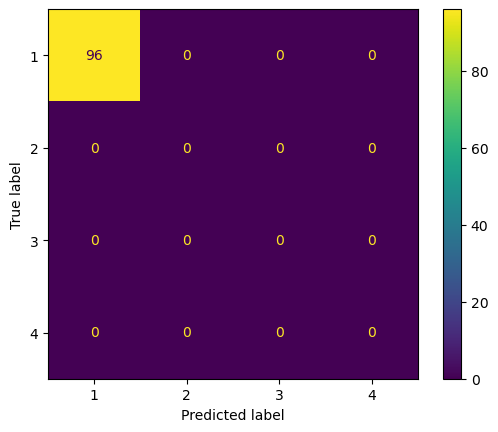

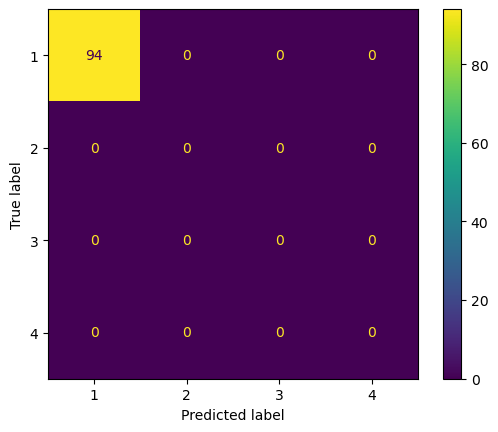

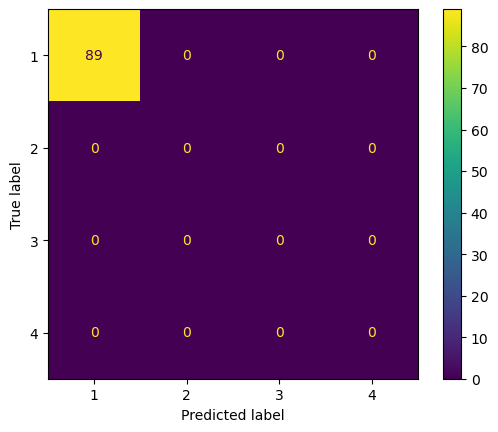

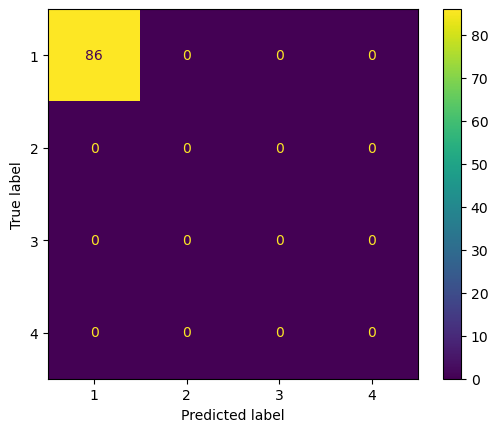

In [71]:
nb_results = loops.loop_model(nb, bin_df, train_indices, valid_indices, scaler=scaler, inc_cm=True)
analyze_k.average_outcome(nb_results)

In [72]:
avg_nb = analyze_k.average_outcome(nb_results)
avg_nb

{'accuracy': 0.7292255892255893,
 'f1': 0.7481186203520743,
 'Macro f1': 0.6736515839684861,
 'recall_non_pov': 0.7345202880994638,
 'recall_pov': 0.710788334472545,
 'precision_non_pov': 0.8986702256191526,
 'precision_pov': 0.43446361181483895}

#### Random Forest

In [73]:
clf_results = loops.loop_model(clf, bin_df, train_indices, valid_indices, scaler=scaler, inc_cm=False)

In [74]:
avg_clf = analyze_k.average_outcome(clf_results)
avg_clf

{'accuracy': 0.8106318082788672,
 'f1': 0.784501940779923,
 'Macro f1': 0.6582338573586523,
 'recall_non_pov': 0.9514926143993389,
 'recall_pov': 0.32073365231259965,
 'precision_non_pov': 0.8297311645671999,
 'precision_pov': 0.6567816176827006}

#### KNN

In [75]:
knn_results = loops.loop_model(knn, bin_df, train_indices, valid_indices, scaler=scaler, inc_cm=False)

In [76]:
avg_knn = analyze_k.average_outcome(knn_results)
avg_knn

{'accuracy': 0.7843906855671562,
 'f1': 0.7327643703066788,
 'Macro f1': 0.557425329355331,
 'recall_non_pov': 0.9653529406240903,
 'recall_pov': 0.15512645249487353,
 'precision_non_pov': 0.7990422442522206,
 'precision_pov': 0.5518066188197768}

#### Logistic Regression

{'accuracy': 0.6841575418046005,
 'f1': 0.7088801468759518,
 'Macro f1': 0.6346421917470952,
 'recall_non_pov': 0.6773436252828878,
 'recall_pov': 0.7077922077922078,
 'precision_non_pov': 0.8897743378949668,
 'precision_pov': 0.3876232868559817}

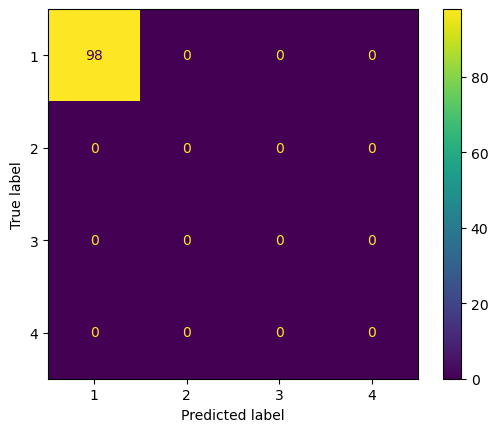

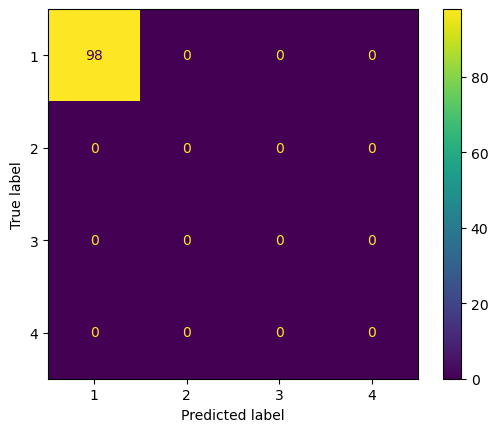

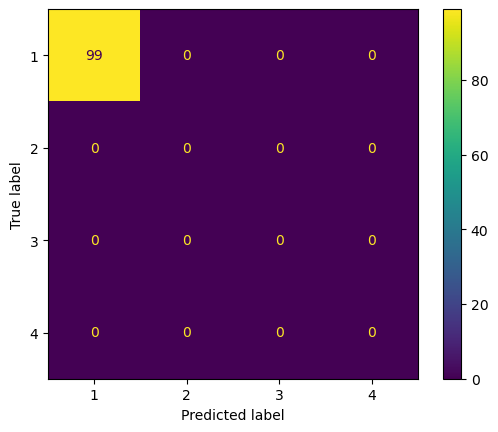

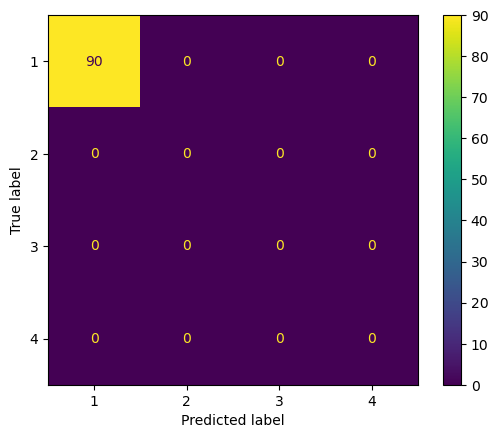

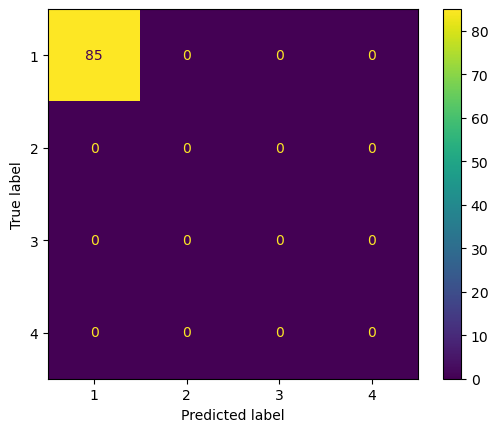

In [77]:
reg = LogisticRegression(solver='liblinear', penalty='l2')
results = loops.loop_model(reg,bin_df,train_indices,valid_indices,oversample=ld.gen_SMOTE_data,var_thresh=True)
avg = analyze_k.average_outcome(results)
avg

### Two Stage Binary Model

In [78]:
from sklearn.preprocessing import MinMaxScaler

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Stage 1: create a binary target separating classes 1/2 from 3/4
y_train_binary = y_train.copy()
y_train_binary[y_train_binary.isin([1, 2])] = 1
y_train_binary[y_train_binary.isin([3, 4])] = 0

# Fit the first model
model_1_2_vs_3_4 = ComplementNB()
model_1_2_vs_3_4.fit(X_train_scaled, y_train_binary)

# Make predictions and evaluate
y_pred = model_1_2_vs_3_4.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

# Stage 2: separate class 1 from class 2
mask_1_2 = y_train_binary == 1
model_1_vs_2 = ComplementNB()
model_1_vs_2.fit(X_train_scaled[mask_1_2], y_train[mask_1_2])

# Make predictions and evaluate
y_pred = model_1_vs_2.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

# Stage 3: separate class 3 from class 4
mask_3_4 = y_train_binary == 0
model_3_vs_4 = ComplementNB()
model_3_vs_4.fit(X_train_scaled[mask_3_4], y_train[mask_3_4])

# Make predictions and evaluate
y_pred = model_3_vs_4.predict(X_test_scaled)
evaluate_classification(y_pred, y_test)

NameError: name 'X_test' is not defined